In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import class_weight
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [4]:
images, annotations = load_data("../../../../images/", '../../../../emo-at-cap.csv')

# Processing of data

In [5]:
import nltk

In [6]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [7]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [8]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [9]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.hstack(tokenized)), np.hstack(tokenized))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=["'" ',' '-' ... 'youth' 'исходный' 'текст'], y=['the' 'man' 'is' ... 'with' 'some' 'clothes'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [10]:
frequency = sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

In [11]:
frequency

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [12]:
len(unique_tokens)

2162

In [13]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [14]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [15]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [16]:
def padd(sentences, pad_token, start_token, end_token, maxlen=10):
    padded_sentences = []
    for i in sentences:
        sentence = [start_token] + i + [end_token]
        if len(sentence)>=maxlen+2:
            sentence = sentence[:maxlen+2]
        else:
            sentence = sentence+[pad_token for i in range(maxlen+2-len(sentence))]
        padded_sentences.append(sentence)
    return padded_sentences

In [17]:
padded_sentences = padd(tokenized, pad_token, start_token, end_token, maxlen=10)

In [18]:
np.mean([len(i) for i in padded_sentences])

12.0

In [19]:
indexed = list(map(lambda x: [vocab[i] for i in x],padded_sentences))

In [20]:
images.shape

(3840, 224, 224, 3)

In [21]:
len(class_weights)

2162

In [22]:
class_weights = list(class_weights)
class_weights.insert(0, 1)
class_weights.insert(1, 1)
class_weights.insert(2, 1)

In [23]:
len(class_weights), len(vocab)

(2165, 2165)

In [24]:
class_weights[:4]

[1, 1, 1, 0.21013259327782918]

In [25]:
class_weights = np.array(class_weights)

In [26]:
class_weights.shape

(2165,)

# Model with transfer learning

In [27]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [28]:
import tensorflow.keras.applications as apps


In [29]:
class ConvEncoder(tf.keras.Model):
    def __init__(self, trainable=False):
        super(ConvEncoder, self).__init__()
        #loading pretrained encoder
        self.encoder = tf.keras.models.load_model('encoder.h5')
        self.encoder.trainable=trainable
        
        #on top layers
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        
    def call(self, input):
        features = self.encoder(input)
        return self.dense1(features)

In [30]:
conv_encoder = ConvEncoder()

In [31]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [32]:
conv_res

<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
array([[0.        , 0.03138161, 0.90139997, 0.1530464 , 0.        ,
        0.        , 0.4331551 , 1.448478  , 0.        , 0.        ,
        0.54014516, 0.        , 0.2345208 , 0.        , 1.7599672 ,
        2.2833786 , 0.        , 0.6446878 , 0.        , 0.        ,
        1.9025598 , 0.08810303, 0.11903951, 0.        , 0.10451436,
        1.6270452 , 1.5704622 , 0.        , 0.17368805, 0.94622743,
        0.7156482 , 0.92243934, 0.49381304, 0.        , 0.32112542,
        0.21971312, 0.9188378 , 0.        , 0.34695274, 1.339732  ,
        0.        , 2.4649563 , 0.8559554 , 2.1452699 , 0.27313313,
        0.609342  , 2.0705836 , 0.        , 0.        , 0.42723823,
        0.        , 0.20286131, 0.9459039 , 0.        , 0.        ,
        0.        , 0.        , 1.4409425 , 1.0246812 , 0.        ,
        0.3989364 , 0.        , 0.        , 0.49472904, 1.1246147 ,
        0.        , 0.        , 0.        , 0.        , 0.5746299 

### LSTM model

### making w2v embeddings

In [33]:
!pip install gensim

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [34]:
import gensim.downloader as api

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [35]:
w2v_embeddings = api.load('word2vec-google-news-300')

In [36]:
def build_embeddings(vocab, word_vectors, embed_dim):
    emb_matrix = np.zeros(shape=(len(vocab)+ 1 , embed_dim), dtype='float32')
    count = 0
    for word, i in vocab.items():
        try:
            emb_matrix[i, :] = word_vectors.get_vector(word)
        except:
            count += 1
            emb_matrix[i, :] = np.random.uniform(-0.1, 0.1, embed_dim)
    print('{} words are out of vocabulary：'.format(count))
    return emb_matrix


In [37]:
w2v_embeddings = build_embeddings(vocab, w2v_embeddings, 300)

22 words are out of vocabulary：


### attention

In [38]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### building model

In [39]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, units=512, embeddings=None, dim=128):
        super(LSTMDecoder, self).__init__()
        self.units = units
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=dim, name='embeddings',
                                                   weights=[embeddings])
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.lstm = tf.keras.layers.LSTM(units=self.units, return_state=True, return_sequences=True, name='lstm_decoder', 
                                         recurrent_dropout=0.1,recurrent_initializer='glorot_uniform')
        self.intermidiate_dense = tf.keras.layers.Dense(units=self.units, activation='relu')
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        self.attention = BahdanauAttention(self.units)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='layer_normalization')

    def call(self, input, features, hidden):
        embedded = self.dropout(self.embeddings(input))
        context_vector, attention_weights = self.attention(features, hidden)
        concated = tf.concat([tf.expand_dims(context_vector, 1), embedded], axis=-1)
        result_lstm, state_h, state_c = self.lstm(concated)
        intermidiate_dense = self.intermidiate_dense(self.layer_norm(result_lstm))
        intermidiate_dense = tf.reshape(intermidiate_dense, (-1, intermidiate_dense.shape[2]))
        logits = self.output_dense(intermidiate_dense)
        return logits, state_h, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [40]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), 256, w2v_embeddings, dim=300)

### Training

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-4
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)
with_weights = False

In [43]:
epochs = 30
batch_size = 64
patience_epochs = 2

In [44]:
def loss_function(real, pred, loss_weights):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_weights = tf.cast(loss_weights, dtype=loss_.dtype)
        loss_*=loss_weights
        return loss_

In [45]:
@tf.function
def train_step(image, target, lengths, optimizer):
    hidden = lstm_decoder.reset_state(batch_size=target.shape[0])

    with tf.GradientTape() as tape:
        features = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, hidden, _ = lstm_decoder(dec_input, features, hidden)
            weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
            weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
            batched_loss.append(loss_function(target[:, t], result, weights))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [46]:
@tf.function
def evaluate(image, target, lengths, optimizer):
    hidden = lstm_decoder.reset_state(batch_size=target.shape[0])

    features = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, hidden, _ = lstm_decoder(dec_input, features, hidden)
        weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
        weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
        batched_loss.append(loss_function(target[:, t], result, weights))
    
    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)
    perplexity = tf.exp(loss)


    return loss, perplexity

In [47]:
train_images, val_images, train_sequences, val_sequences =  train_test_split(images, indexed, test_size=0.2, random_state=10)
val_images, test_images, val_sequences, test_sequences =  train_test_split(val_images, val_sequences, test_size=0.5, random_state=10)

In [48]:
train_length = (np.array(train_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [49]:
val_length = (np.array(val_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [50]:
test_length = (np.array(test_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [51]:
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size))
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size))
val_images = np.array(np.array_split(val_images, len(val_images)//batch_size))

train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
val_sequences = np.array(np.array_split(val_sequences, len(val_sequences)//batch_size))

train_length = np.array(np.array_split(train_length, len(train_length)//batch_size))
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size))
val_length = np.array(np.array_split(val_length, len(val_length)//batch_size))


In [52]:
train_images.shape, train_sequences.shape, train_length.shape

((48, 64, 224, 224, 3), (48, 64, 12), (48, 64))

In [53]:
!pip install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [54]:
if not with_weights:
    class_weights = np.array([1 for i in range(len(class_weights))])

In [55]:
from tqdm import tqdm

In [56]:
train_loss = []
train_perplexity = []
val_loss = []
val_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_val_loss = 0
    epoch_val_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length in tqdm(zip(train_images,train_sequences,train_length)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_val_images, batch_val_sequences, batched_val_length in zip(val_images,val_sequences,val_length):
        batched_val_loss, batched_val_perplexity = evaluate(batch_val_images, batch_val_sequences, batched_val_length, optimizer)
        epoch_val_loss+=batched_val_loss
        epoch_val_perplexity+=batched_val_perplexity
    epoch_val_loss = epoch_val_loss/val_images.shape[0]
    epoch_val_perplexity = epoch_val_perplexity/val_images.shape[0]
    val_perplexity.append(epoch_val_perplexity)
    val_loss.append(epoch_val_loss)
    print('Validation loss : {}; Validation perplexity : {}'.format(epoch_val_loss,epoch_val_perplexity))
    if len(val_loss)>=2 and val_loss[-2]<val_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in validation loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

48it [00:30,  1.56it/s]


Finished epoch 0; Train loss : 7.148754119873047; Train perplexity : 2008.6572265625
Validation loss : 5.8430705070495605; Validation perplexity : 347.8597717285156


48it [00:09,  4.96it/s]


Finished epoch 1; Train loss : 5.311950206756592; Train perplexity : 209.6133575439453
Validation loss : 5.026675224304199; Validation perplexity : 153.82073974609375


48it [00:09,  4.96it/s]


Finished epoch 2; Train loss : 4.705038547515869; Train perplexity : 112.4383544921875
Validation loss : 4.6336565017700195; Validation perplexity : 104.04580688476562


48it [00:09,  4.97it/s]


Finished epoch 3; Train loss : 4.343700885772705; Train perplexity : 78.16950225830078
Validation loss : 4.385531902313232; Validation perplexity : 81.44990539550781


48it [00:09,  4.96it/s]


Finished epoch 4; Train loss : 4.102421283721924; Train perplexity : 61.359588623046875
Validation loss : 4.234541893005371; Validation perplexity : 70.2569351196289


48it [00:09,  4.96it/s]


Finished epoch 5; Train loss : 3.933793306350708; Train perplexity : 51.806270599365234
Validation loss : 4.143736362457275; Validation perplexity : 64.3253173828125


48it [00:09,  4.97it/s]


Finished epoch 6; Train loss : 3.8091983795166016; Train perplexity : 45.708770751953125
Validation loss : 4.08855676651001; Validation perplexity : 61.00557327270508


48it [00:09,  4.92it/s]


Finished epoch 7; Train loss : 3.7123517990112305; Train perplexity : 41.4634895324707
Validation loss : 4.044228553771973; Validation perplexity : 58.46043014526367


48it [00:09,  4.96it/s]


Finished epoch 8; Train loss : 3.6352698802948; Train perplexity : 38.36201095581055
Validation loss : 3.994999885559082; Validation perplexity : 55.709835052490234


48it [00:09,  4.94it/s]


Finished epoch 9; Train loss : 3.5724637508392334; Train perplexity : 36.0172004699707
Validation loss : 3.9948904514312744; Validation perplexity : 55.80400085449219


48it [00:09,  4.95it/s]


Finished epoch 10; Train loss : 3.514669418334961; Train perplexity : 33.976966857910156
Validation loss : 3.9968650341033936; Validation perplexity : 55.97175979614258


48it [00:09,  4.95it/s]


Finished epoch 11; Train loss : 3.467050790786743; Train perplexity : 32.37214279174805
Validation loss : 4.01452112197876; Validation perplexity : 57.07469177246094
There was no improvement in validation loss for 2 epochs, thus reducing learning rate


48it [00:09,  4.94it/s]


Finished epoch 12; Train loss : 3.4202401638031006; Train perplexity : 30.888273239135742
Validation loss : 3.9537734985351562; Validation perplexity : 53.652252197265625


48it [00:09,  4.92it/s]


Finished epoch 13; Train loss : 3.4108760356903076; Train perplexity : 30.597192764282227
Validation loss : 3.9527175426483154; Validation perplexity : 53.59262466430664


48it [00:09,  4.98it/s]


Finished epoch 14; Train loss : 3.405482053756714; Train perplexity : 30.431793212890625
Validation loss : 3.9521408081054688; Validation perplexity : 53.5659065246582


48it [00:09,  4.93it/s]


Finished epoch 15; Train loss : 3.400590658187866; Train perplexity : 30.282150268554688
Validation loss : 3.951976776123047; Validation perplexity : 53.563419342041016


48it [00:09,  4.96it/s]


Finished epoch 16; Train loss : 3.395892858505249; Train perplexity : 30.139158248901367
Validation loss : 3.9518325328826904; Validation perplexity : 53.56246566772461


48it [00:09,  4.93it/s]


Finished epoch 17; Train loss : 3.391317367553711; Train perplexity : 30.00042152404785
Validation loss : 3.9518215656280518; Validation perplexity : 53.56863784790039


48it [00:09,  4.93it/s]


Finished epoch 18; Train loss : 3.386821746826172; Train perplexity : 29.86484718322754
Validation loss : 3.9517805576324463; Validation perplexity : 53.57363510131836


48it [00:09,  4.95it/s]


Finished epoch 19; Train loss : 3.382391929626465; Train perplexity : 29.73174285888672
Validation loss : 3.95186710357666; Validation perplexity : 53.58552932739258


48it [00:09,  4.96it/s]


Finished epoch 20; Train loss : 3.378037214279175; Train perplexity : 29.601533889770508
Validation loss : 3.952082395553589; Validation perplexity : 53.6054801940918
There was no improvement in validation loss for 2 epochs, thus reducing learning rate


48it [00:09,  4.95it/s]


Finished epoch 21; Train loss : 3.373211145401001; Train perplexity : 29.45909309387207
Validation loss : 3.95005202293396; Validation perplexity : 53.49168014526367


48it [00:09,  4.95it/s]


Finished epoch 22; Train loss : 3.3725547790527344; Train perplexity : 29.438936233520508
Validation loss : 3.9495954513549805; Validation perplexity : 53.4657096862793


48it [00:09,  4.96it/s]


Finished epoch 23; Train loss : 3.372028350830078; Train perplexity : 29.423070907592773
Validation loss : 3.9494850635528564; Validation perplexity : 53.459346771240234


48it [00:09,  4.86it/s]


Finished epoch 24; Train loss : 3.3715403079986572; Train perplexity : 29.408525466918945
Validation loss : 3.9494435787200928; Validation perplexity : 53.4571418762207


48it [00:09,  4.96it/s]


Finished epoch 25; Train loss : 3.3710734844207764; Train perplexity : 29.394638061523438
Validation loss : 3.94941782951355; Validation perplexity : 53.45600509643555


48it [00:09,  4.96it/s]


Finished epoch 26; Train loss : 3.3706181049346924; Train perplexity : 29.38114356994629
Validation loss : 3.9494030475616455; Validation perplexity : 53.455753326416016


48it [00:09,  4.91it/s]


Finished epoch 27; Train loss : 3.370171308517456; Train perplexity : 29.367921829223633
Validation loss : 3.949388265609741; Validation perplexity : 53.45561599731445


48it [00:09,  4.94it/s]


Finished epoch 28; Train loss : 3.3697288036346436; Train perplexity : 29.3548641204834
Validation loss : 3.9493720531463623; Validation perplexity : 53.45549392700195


48it [00:09,  4.96it/s]


Finished epoch 29; Train loss : 3.3692901134490967; Train perplexity : 29.34189796447754
Validation loss : 3.9493601322174072; Validation perplexity : 53.45560073852539


# Viewing and saving results

In [57]:
df = pd.DataFrame()
model_name = 'conv_lstm_transfer_learning_w2v_autoenc_fixed_size_attention'
df['train_perplexity'] = [i.numpy() for i in train_perplexity]
df['val_perplexity'] = [i.numpy() for i in val_perplexity]
df['train_loss'] = [i.numpy() for i in train_loss]
df['val_loss'] = [i.numpy() for i in val_loss]


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

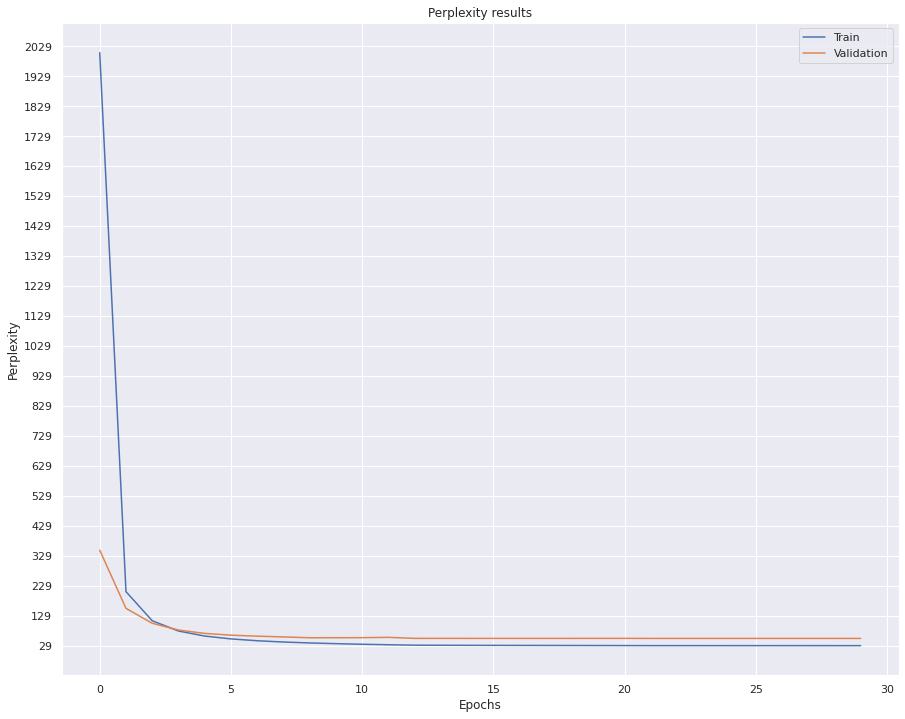

In [59]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity'])
plt.plot(df['val_perplexity'])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity']), max(df['train_perplexity'])+100,100))
plt.legend(['Train', 'Validation']);

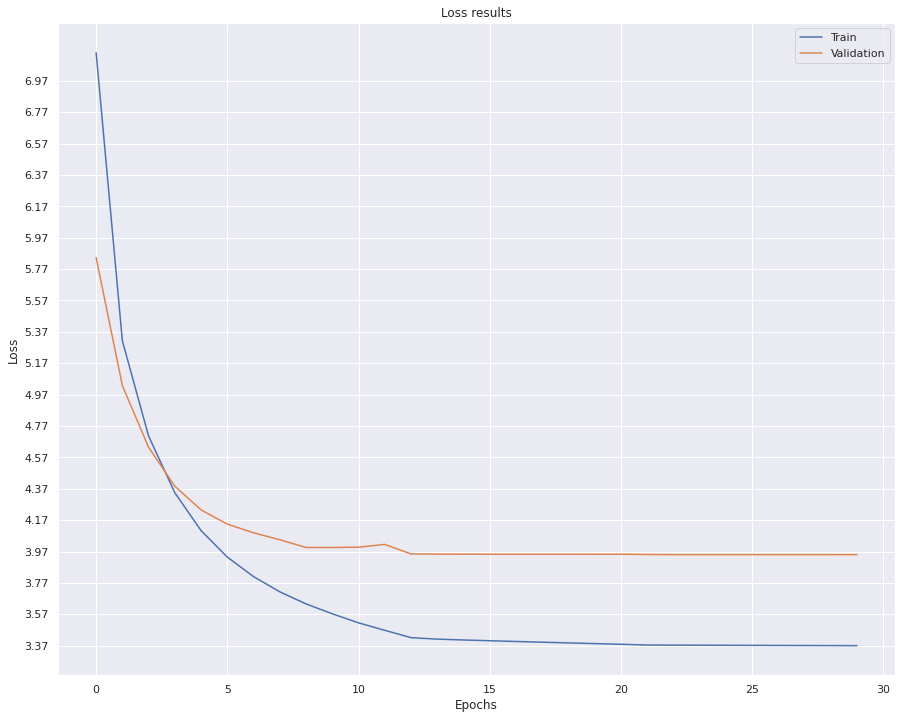

In [60]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss'])
plt.plot(df['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss']),max(df['train_loss']),0.2))
plt.legend(['Train', 'Validation']);

# Testing model

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = None,
                 units:int = 256):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len if max_len else 100
        self.start_token = start_token
        self.end_token = end_token
        self.units = units

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 units:int = 256
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len,
                         units
                         )

    def decode(self, input):
        features = self.encoder(np.expand_dims(input, axis=0))
        hidden = np.zeros((1,self.units))
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token
        res = []
        while True:
            # Sample a token
            output, hidden, _ = self.decoder(target_seq,features,hidden)
            sampled_token_index = np.argmax(tf.nn.softmax(output.numpy()))
            if len(res) > self.max_len or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [63]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 units:int = 256
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len,
                         units
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        features = self.encoder(np.expand_dims(input,axis=0))

        hidden = np.zeros((1,self.units))
        start_word = [[start, 0.0, hidden]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                hidden = s[-1]
                output, hidden, _ = self.decoder(target_seq, features, hidden)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, hidden])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [64]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [65]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10, units=256)

In [66]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10, units=256)

In [67]:
images.shape

(3840, 224, 224, 3)

In [68]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

the happy couple is hugging in front of camera


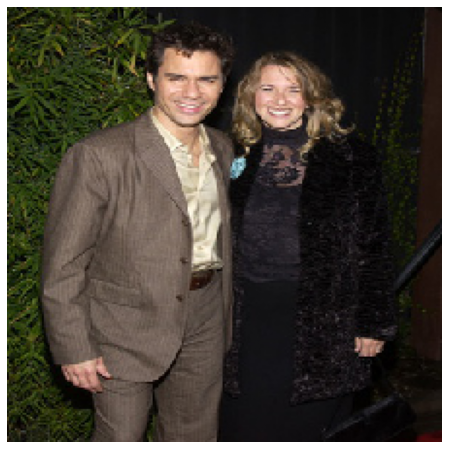

In [69]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [70]:
predict(sample, greedy_decoder, inverse_vocab)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



'the woman'

In [71]:
predict(sample, beam_decoder, inverse_vocab, beam_size=3)

'men are having a woman'

In [72]:
predict(sample, beam_decoder, inverse_vocab, beam_size=5)

'men are laughing at something'

In [73]:
predict(sample, beam_decoder, inverse_vocab, beam_size=7)

'men are worried about something'

In [74]:
predict(sample, beam_decoder, inverse_vocab, beam_size=10)

'men are trying to men are trying to the'

# Blue score calculation

In [75]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [76]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

100%|██████████| 6/6 [04:44<00:00, 47.49s/it]


In [77]:
test_predictions = [i.split(' ') for i in test_predictions]

In [78]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [79]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [80]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction))
print('Overall bleu score on test data : {}'.format(np.mean(bleu_score)))
df['overall_bleu'] = np.mean(bleu_score)*100

Overall bleu score on test data : 0.0008218709737273294


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

In [81]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(1,)))
print('Bleu score on test data for n-gram = 1 : {}'.format(np.mean(bleu_score)))
df['n1_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 1 : 0.13776217548716652


In [82]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,1)))
print('Bleu score on test data for n-gram = 2 : {}'.format(np.mean(bleu_score)))
df['n2_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 2 : 0.04062222474965053


In [83]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,1)))
print('Bleu score on test data for n-gram = 3 : {}'.format(np.mean(bleu_score)))
df['n3_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 3 : 0.008252221455350156


In [84]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,0,1)))
print('Bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['n4_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 4 : 0.0004340277777777778


In [85]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0.25,0.25,0.25,0.25)))
print('Acuumulated bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['acc_bleu'] = np.mean(bleu_score)*100

Acuumulated bleu score on test data for n-gram = 4 : 0.0008218709737273294


In [86]:
df.head()

,train_perplexity,val_perplexity,train_loss,val_loss,overall_bleu,n1_bleu,n2_bleu,n3_bleu,n4_bleu,acc_bleu
0,2008.657227,347.859772,7.148754,5.843071,0.082187,13.776218,4.062222,0.825222,0.043403,0.082187
1,209.613358,153.820740,5.311950,5.026675,0.082187,13.776218,4.062222,0.825222,0.043403,0.082187
2,112.438354,104.045807,4.705039,4.633657,0.082187,13.776218,4.062222,0.825222,0.043403,0.082187
3,78.169502,81.449905,4.343701,4.385532,0.082187,13.776218,4.062222,0.825222,0.043403,0.082187
4,61.359589,70.256935,4.102421,4.234542,0.082187,13.776218,4.062222,0.825222,0.043403,0.082187


In [87]:
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [88]:
conv_encoder.save_weights('{}_encoder.h5'.format(model_name))

In [89]:
lstm_decoder.save_weights('{}_decoder.h5'.format(model_name))

# Predictions on own data

In [90]:
img = np.array(im.load_img('hospital-birth.jpg', target_size=(224,224)))/255

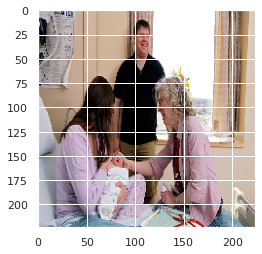

In [91]:
plt.imshow(img)

In [92]:
predict(img, greedy_decoder, inverse_vocab)

'the the the the the the the the the the the'

In [93]:
predict(img, beam_decoder, inverse_vocab, beam_size=3)

'the woman'

In [94]:
predict(img, beam_decoder, inverse_vocab, beam_size=5)

'the woman'

In [95]:
predict(img, beam_decoder, inverse_vocab, beam_size=7)

'the woman'

In [96]:
predict(img, beam_decoder, inverse_vocab, beam_size=10)

'the woman'